Importing libraries

In [1]:
%pip install scikit-optimize
%pip install optuna
import pandas as pd
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
import numpy as np
import os
import re
import subprocess
import time
import optuna
import shutil
import matplotlib.pyplot as plt
import seaborn as sns

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Making the dataset

In [2]:
def generate_column_names(absorbers, HTLs, ETLs):
    """
    Generate dataset column names based on user-defined absorber, HTL, and ETL materials.
    """
    column_names = []
    
    # One-hot encoded material columns
    column_names += [f"absorber_{mat}" for mat in absorbers]
    column_names += [f"HTL_{mat}" for mat in HTLs]
    column_names += [f"ETL_{mat}" for mat in ETLs]
    
    # Additional numerical feature columns
    column_names += [
        "absorber_thickness", "HTL_thickness", "ETL_thickness", 
        "absorber_NA", "absorber_ND", "HTL_NA", "ETL_ND"
    ]

    # Additional output columns
    column_names += ["Voc", "Jsc", "FF", "eta"]
    
    return column_names

# Example usage
absorbers = ["CsPbBr3", "CsPbI3"]
HTLs = ["Cu2O", "Sprio-OMeTAD"]
ETLs = ["PCBM", "TiO2"]

# Define search space for numerical features
search_space = {
    "absorber_thickness": (0.05, 3),  # in um
    "HTL_thickness": (0.015, 2),       # in um
    "ETL_thickness": (0.015, 2),       # in um
    "absorber_NA": (1e13, 1e19),      # in cm^-3
    "absorber_ND": (1e13, 1e19),      # in cm^-3
    "HTL_NA": (1e12, 1e21),          # in cm^-3
    "ETL_ND": (1e12, 1e21)           # in cm^-3
}

dataset_columns = generate_column_names(absorbers, HTLs, ETLs)
print(dataset_columns)

# Define Bayesian Optimization search space
space = [
    Categorical(absorbers, name="absorber"),
    Categorical(HTLs, name="HTL"),
    Categorical(ETLs, name="ETL"),
    Real(*search_space["absorber_thickness"], name="absorber_thickness"),
    Real(*search_space["HTL_thickness"], name="HTL_thickness"),
    Real(*search_space["ETL_thickness"], name="ETL_thickness"),
    Real(*search_space["absorber_NA"], name="absorber_NA"),
    Real(*search_space["absorber_ND"], name="absorber_ND"),
    Real(*search_space["HTL_NA"], name="HTL_NA"),
    Real(*search_space["ETL_ND"], name="ETL_ND"),
]

def dummy_objective(params):
    return np.random.rand()  # Placeholder for actual SCAPS feedback

# Generate 10 initial instances
instances = []
for _ in range(10):
    instance = {}
    for dim in space:
        value = dim.rvs(random_state=np.random.randint(1000))
        if isinstance(value, list):  # Ensure single value is extracted
            value = value[0]
        instance[dim.name] = value
    instances.append(instance)

# Convert to DataFrame
instances_df = pd.DataFrame(instances)

# Convert numerical columns to float, replacing NaN with column means
numerical_columns = [
    "absorber_thickness", "HTL_thickness", "ETL_thickness", 
    "absorber_NA", "absorber_ND", "HTL_NA", "ETL_ND"
]
for col in numerical_columns:
    instances_df[col] = pd.to_numeric(instances_df[col], errors='coerce')
    instances_df[col].fillna(instances_df[col].mean(), inplace=True)  # Fill NaN with column mean

# One-hot encode material selection
instances_df = pd.get_dummies(instances_df, columns=["absorber", "HTL", "ETL"], prefix=["absorber", "HTL", "ETL"])

# Convert boolean columns (one-hot encoded) to integers (0 and 1)
bool_columns = instances_df.select_dtypes(include=['bool']).columns
instances_df[bool_columns] = instances_df[bool_columns].astype(int)

# Add additional output columns initialized to 0
instances_df[["Voc", "Jsc", "FF", "eta"]] = 0

# Print final dataset
print(instances_df.dtypes)
print(instances_df)



['absorber_CsPbBr3', 'absorber_CsPbI3', 'HTL_Cu2O', 'HTL_Sprio-OMeTAD', 'ETL_PCBM', 'ETL_TiO2', 'absorber_thickness', 'HTL_thickness', 'ETL_thickness', 'absorber_NA', 'absorber_ND', 'HTL_NA', 'ETL_ND', 'Voc', 'Jsc', 'FF', 'eta']
absorber_thickness    float64
HTL_thickness         float64
ETL_thickness         float64
absorber_NA           float64
absorber_ND           float64
HTL_NA                float64
ETL_ND                float64
absorber_CsPbBr3        int32
absorber_CsPbI3         int32
HTL_Cu2O                int32
HTL_Sprio-OMeTAD        int32
ETL_PCBM                int32
ETL_TiO2                int32
Voc                     int64
Jsc                     int64
FF                      int64
eta                     int64
dtype: object
   absorber_thickness  HTL_thickness  ETL_thickness   absorber_NA  \
0            1.168341       0.741868       1.462092  9.878087e+18   
1            0.265908       1.407253       0.557724  5.627235e+18   
2            2.084052       0.039847    

C:\Users\Naimur Rahman\AppData\Local\Temp\ipykernel_11768\3090252056.py:80: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  instances_df[col].fillna(instances_df[col].mean(), inplace=True)  # Fill NaN with column mean


Generate initial data

In [3]:
# File paths
destination_file = "../def/yt_test_all_settings.scaps"

def update_definition_file(definition_file, absorber_data, etl_data, htl_data):
    try:
        with open(definition_file, "r", encoding="utf-8") as file:
            content = file.read()
    except UnicodeDecodeError:
        with open(definition_file, "r", encoding="latin-1") as file:
            content = file.read()

    # Update maxiter
    content = re.sub(r"^maxiter : \*0000", "maxiter : 1000000", content, flags=re.MULTILINE)


    # Replace absorber section
    content = re.sub(
    r"(name : absorber_.*?Et :[^\n]*\n)",
    absorber_data + "\n",
    content,
    flags=re.DOTALL
    )

    # Replace ETL section
    content = re.sub(
    r"(name : ETL_.*?Et :[^\n]*\n)",
    etl_data + "\n",
    content,
    flags=re.DOTALL
    )

    # Replace HTL section
    content = re.sub(
    r"(name : HTL_.*?Et :[^\n]*\n)",
    htl_data + "\n",
    content,
    flags=re.DOTALL
    )


    # Save the updated file
    with open(definition_file, "w", encoding="utf-8") as file:
        file.write(content)

# Function to read and extract data from material files
def read_material_file(file_path, thickness_value, na_value=None, nd_value=None):
        if not file_path:
            return None
        try:
            with open(file_path, "r", encoding="utf-8") as file:
                content = file.read()
        except UnicodeDecodeError:
            with open(file_path, "r", encoding="latin-1") as file:
                content = file.read()

        match = re.search(r"material name.*", content, re.DOTALL)
        
        if match:
            extracted_text = re.sub(r"^material ", "", match.group(), count=1)  # Clean material name
            #extracted_text = re.sub(r"(d :\s*)[\d\.e\+\-]+", lambda m: f"{m.group(1)}{thickness_value:.3e}", extracted_text)
            # extracted_text = re.sub(r"^d :", f"d : {thickness_value} [\u00b5m]", extracted_text)
            extracted_text = re.sub(r"^d :.*", f"d : {thickness_value / 1e6:.9e} [m]", extracted_text, flags=re.MULTILINE)

            # Placeholder for inserting NA and ND values in the material file
            if na_value:
                #find next occurrence of "Na(uniform) :" after the first occurrence of "d :"
                #replace the line such that it would look like this:
                #Na(uniform) :	 {na_value:.6e}	 {na_value:.6e}	 1.000000e+01	 1.000000e+01	 1.000000e+01	 {na_value:.6e}	 {na_value:.6e}	 0	 2	[/cm^3]
                extracted_text = re.sub(
                r"(Na\(uniform\)\s*:\s*)([\d\.e\+\-\s]+)(\[/cm\^3\])",
                lambda m: f"{m.group(1)}{na_value:.6e}\t{na_value:.6e}\t1.000000e+01\t1.000000e+01\t1.000000e+01\t{na_value:.6e}\t{na_value:.6e}\t0\t2\t{m.group(3)}",
                extracted_text,
                count=1  # Ensure we only replace the first occurrence
            )

            if nd_value:
                #find next occurrence of "Nd(uniform) :" after the first occurrence of "d :"
                #replace the line such that it would look like this:
                #Nd(uniform) :	 {nd_value:.6e}	 {nd_value:.6e}	 1.000000e+01	 1.000000e+01	 1.000000e+01	 {nd_value:.6e}	 {nd_value:.6e}	 0	 2	[/cm^3]
                extracted_text = re.sub(
                r"(Nd\(uniform\)\s*:\s*)([\d\.e\+\-\s]+)(\[/cm\^3\])",
                lambda m: f"{m.group(1)}{nd_value:.6e}\t{nd_value:.6e}\t1.000000e+01\t1.000000e+01\t1.000000e+01\t{nd_value:.6e}\t{nd_value:.6e}\t0\t2\t{m.group(3)}",
                extracted_text,
                count=1  # Ensure we only replace the first occurrence
            )
            return extracted_text
        else:
            return None

def run_scaps_and_monitor(script_name="yt_test.script", results_dir="../results", output_file="yt_save.iv", timeout=60):
    """
    Runs SCAPS and terminates it once the output file is updated or if it gets stuck.

    Args:
        script_name (str): Name of the SCAPS script to run (default: "yt_test.script")
        results_dir (str): Directory where results are stored (default: "../results")
        output_file (str): File to monitor for changes (default: "yt_save.iv")
        timeout (int): Maximum time (in seconds) to wait for SCAPS before forcing termination.
    """
    file_to_watch = os.path.join(results_dir, output_file)
    initial_mtime = os.path.getmtime(file_to_watch) if os.path.exists(file_to_watch) else None
    
    # Run SCAPS
    process = subprocess.Popen(
        f"scaps3310.exe {script_name}",
        shell=True,
        cwd=os.path.dirname(results_dir))  # Move up to parent directory of results
    
    start_time = time.time()
    try:
        while True:
            time.sleep(1)
            if os.path.exists(file_to_watch):
                current_mtime = os.path.getmtime(file_to_watch)
                if current_mtime != initial_mtime:
                    print("File updated! Killing SCAPS...")
                    subprocess.run("taskkill /F /IM scaps3310.exe", shell=True)
                    break
            
            # Check if timeout exceeded
            if time.time() - start_time > timeout:
                print("SCAPS stuck! Killing process and moving on...")
                subprocess.run("taskkill /F /IM scaps3310.exe", shell=True)
                break
    
    except KeyboardInterrupt:
        subprocess.run("taskkill /F /IM scaps3310.exe", shell=True)
        print("Terminated by user.")

def update_instance_from_iv(instance, iv_file_path="../results/yt_save.iv"):
    try:
        with open(iv_file_path, "r", encoding="utf-8") as file:
            content = file.read()
    except UnicodeDecodeError:
        with open(iv_file_path, "r", encoding="latin-1") as file:
            content = file.read()

    # Define regex patterns for extracting values
    patterns = {
        "Voc": r"Voc\s*=\s*([\d\.]+)\s*Volt",
        "Jsc": r"Jsc\s*=\s*([\d\.]+)\s*mA/cm2",
        "FF": r"FF\s*=\s*([\d\.]+)\s*%",
        "eta": r"eta\s*=\s*([\d\.]+)"
    }
    
    # Extract and update values in the instance dictionary
    for key, pattern in patterns.items():
        match = re.search(pattern, content)
        if match:
            instance[key] = float(match.group(1))

    return instance

for index, row in instances_df.iterrows():
    # print(f"Instance {index + 1}:")
    
    absorber_material = None
    ETL_material = None
    HTL_material = None

    # Detect non-zero materials and their thickness
    for key, value in row.items():
        # Skip materials that are zero
        if key.startswith(("absorber_", "HTL_", "ETL_")) and value == 0:
            continue
        
        print(f"  {key}: {value}")

        # Detect the non-zero material names
        if key.startswith("absorber_") and value == 1:
            absorber_material = key.replace("absorber_", "")
        elif key.startswith("ETL_") and value == 1:
            ETL_material = key.replace("ETL_", "")
        elif key.startswith("HTL_") and value == 1:
            HTL_material = key.replace("HTL_", "")

    # Construct source file paths
    source_file_absorber = f"../materials/absorber_{absorber_material}.material" if absorber_material else None
    source_file_ETL = f"../materials/ETL_{ETL_material}.material" if ETL_material else None
    source_file_HTL = f"../materials/HTL_{HTL_material}.material" if HTL_material else None

    # Read and modify the material files
    absorber_data = read_material_file(source_file_absorber, row["absorber_thickness"], row["absorber_NA"], row["absorber_ND"])
    ETL_data = read_material_file(source_file_ETL, row["ETL_thickness"], None, row["ETL_ND"])
    HTL_data = read_material_file(source_file_HTL, row["HTL_thickness"], row["HTL_NA"], None)

    # Ensure valid material data before processing
    # if absorber_data:
    #     print(f"Extracted absorber data:\n{absorber_data}")
    # if ETL_data:
    #     print(f"Extracted ETL data:\n{ETL_data}")
    # if HTL_data:
    #     print(f"Extracted HTL data:\n{HTL_data}")

    update_definition_file(destination_file, absorber_data, ETL_data, HTL_data)
    # Run scaps script
    if __name__ == "__main__":
        run_scaps_and_monitor()  # Use defaults
        # Alternative call with custom arguments:
        # run_scaps_and_monitor(script_name="custom.script", results_dir="../output", output_file="data.iv")

    updated_instance = update_instance_from_iv(row, iv_file_path="../results/yt_save.iv")
    instances_df.loc[index] = updated_instance  # Update the DataFrame

# print(instances_df)
# Save the updated DataFrame if needed
instances_df.to_csv("updated_instances.csv", index=False)
print("Initial data generated and saved to 'updated_instances.csv'.")

  absorber_thickness: 1.168340650029622
  HTL_thickness: 0.7418679443537496
  ETL_thickness: 1.4620922784439014
  absorber_NA: 9.878086691932699e+18
  absorber_ND: 2.891238169356643e+17
  HTL_NA: 2.900845401263262e+20
  ETL_ND: 3.601522112582049e+20
  absorber_CsPbI3: 1.0
  HTL_Sprio-OMeTAD: 1.0
  ETL_TiO2: 1.0
  Voc: 0.0
  Jsc: 0.0
  FF: 0.0
  eta: 0.0
File updated! Killing SCAPS...


C:\Users\Naimur Rahman\AppData\Local\Temp\ipykernel_11768\1563845327.py:203: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.867881' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  instances_df.loc[index] = updated_instance  # Update the DataFrame
C:\Users\Naimur Rahman\AppData\Local\Temp\ipykernel_11768\1563845327.py:203: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '20.65580574' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  instances_df.loc[index] = updated_instance  # Update the DataFrame
C:\Users\Naimur Rahman\AppData\Local\Temp\ipykernel_11768\1563845327.py:203: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '86.8294' has dtype incompatible with int64, ple

  absorber_thickness: 0.26590843738412345
  HTL_thickness: 1.407252504920329
  ETL_thickness: 0.5577239784572023
  absorber_NA: 5.627235371754674e+18
  absorber_ND: 6.779558702530275e+18
  HTL_NA: 6.995275632612597e+20
  ETL_ND: 3.047816435157037e+20
  absorber_CsPbBr3: 1.0
  HTL_Sprio-OMeTAD: 1.0
  ETL_PCBM: 1.0
  Voc: 0.0
  Jsc: 0.0
  FF: 0.0
  eta: 0.0
File updated! Killing SCAPS...
  absorber_thickness: 2.0840523627114633
  HTL_thickness: 0.03984703177338139
  ETL_thickness: 1.662805947872936
  absorber_NA: 3.534938031333943e+18
  absorber_ND: 7.539794485912715e+18
  HTL_NA: 6.902199083112829e+20
  ETL_ND: 4.4873522074352596e+20
  absorber_CsPbBr3: 1.0
  HTL_Sprio-OMeTAD: 1.0
  ETL_PCBM: 1.0
  Voc: 0.0
  Jsc: 0.0
  FF: 0.0
  eta: 0.0
File updated! Killing SCAPS...
  absorber_thickness: 2.023034002611981
  HTL_thickness: 1.9758001841488249
  ETL_thickness: 1.7760079945312266
  absorber_NA: 7.685047245125382e+17
  absorber_ND: 2.7814281596318147e+18
  HTL_NA: 5.529999263843586e+20
  

Optimization

In [4]:


def objective(trial):
    """
    Objective function for Bayesian optimization using Optuna.
    Focuses on maximizing PCE & Jsc while penalizing excessive thickness and doping.
    """
    global best_PCE, best_thickness
    
    # Suggest new values within defined boundaries
    absorber_thickness = trial.suggest_float("absorber_thickness", 0.05, 3)
    HTL_thickness = trial.suggest_float("HTL_thickness", 0.015, 2)
    ETL_thickness = trial.suggest_float("ETL_thickness", 0.015, 2)
    absorber_NA = trial.suggest_float("absorber_NA", 1e13, 1e19)
    absorber_ND = trial.suggest_float("absorber_ND", 1e13, 1e19)
    HTL_NA = trial.suggest_float("HTL_NA", 1e12, 1e21)
    ETL_ND = trial.suggest_float("ETL_ND", 1e12, 1e21)

    # Randomly choose materials (assuming one-hot encoded material selection)
    absorber_material = np.random.choice([
        re.sub(r"^absorber_", "", col) 
        for col in instances_df.columns 
        if re.match(r"^absorber_[a-zA-Z0-9_]+$", col) and col not in ["absorber_thickness", "absorber_NA", "absorber_ND"]
    ])

    HTL_material = np.random.choice([
        col.replace("HTL_", "") 
        for col in instances_df.columns 
        if col.startswith("HTL_") and col not in ["HTL_thickness", "HTL_NA", "HTL_ND"]
    ])

    ETL_material = np.random.choice([
        col.replace("ETL_", "") 
        for col in instances_df.columns 
        if col.startswith("ETL_") and col not in ["ETL_thickness", "ETL_NA", "ETL_ND"]
    ])

    # Define material file paths
    source_file_absorber = f"../materials/absorber_{absorber_material}.material"
    source_file_HTL = f"../materials/HTL_{HTL_material}.material"
    source_file_ETL = f"../materials/ETL_{ETL_material}.material"

    # Read and modify the material files
    absorber_data = read_material_file(source_file_absorber, absorber_thickness, absorber_NA, absorber_ND)
    HTL_data = read_material_file(source_file_HTL, HTL_thickness, HTL_NA, None)
    ETL_data = read_material_file(source_file_ETL, ETL_thickness, None, ETL_ND)

    if not absorber_data or not HTL_data or not ETL_data:
        return float("inf")  # Return a bad score if material file reading fails

    # Update SCAPS definition file
    update_definition_file(destination_file, absorber_data, ETL_data, HTL_data)

    # Run SCAPS simulation
    run_scaps_and_monitor()

    # Update instance with new results
    instance = {
        "absorber_thickness": absorber_thickness,
        "HTL_thickness": HTL_thickness,
        "ETL_thickness": ETL_thickness,
        "absorber_NA": absorber_NA,
        "absorber_ND": absorber_ND,
        "HTL_NA": HTL_NA,
        "ETL_ND": ETL_ND,
        f"absorber_{absorber_material}": 1,
        f"HTL_{HTL_material}": 1,
        f"ETL_{ETL_material}": 1,
    }

    updated_instance = update_instance_from_iv(instance)

    # Extract target values
    PCE = updated_instance.get("eta", 0)
    Jsc = updated_instance.get("Jsc", 0)

    # Save best SCAPS file if PCE improves
    if PCE > best_PCE:
        best_PCE = PCE
        best_thickness = absorber_thickness + HTL_thickness + ETL_thickness

        # Copy the best SCAPS configuration
        shutil.copy("../def/yt_test_all_settings.scaps", "../def/best_device.scaps")
        print(f"🔹 New best device saved! PCE: {best_PCE:.2f}")

    # Penalty terms
    total_thickness = absorber_thickness + HTL_thickness + ETL_thickness
    doping_penalty = 0.1 * (absorber_NA / 1e18 + absorber_ND / 1e18 + HTL_NA / 1e18 + ETL_ND / 1e18)

    # Thickness penalty: If thickness increases by >2x but PCE gains <0.01, apply penalty
    if total_thickness > 2 * best_thickness and PCE < best_PCE + 0.01:
        thickness_penalty = 5 * (total_thickness - best_thickness)
    else:
        thickness_penalty = 0

    # Final objective function
    score = PCE + 0.1 * Jsc - thickness_penalty - doping_penalty

    # Store the updated instance in the DataFrame
    global instances_opt_df
    instances_opt_df = pd.read_csv("updated_instances.csv")
    instances_opt_df = pd.concat([instances_opt_df, pd.DataFrame([updated_instance])], ignore_index=True)

    return score  # Optimizing this function

# Initialize best values
best_PCE = 0
best_thickness = 1e6  # Arbitrarily large starting value

# Run Bayesian Optimization
study = optuna.create_study(direction="maximize")

prev_best_pce = -float("inf")
no_improvement_count = 0
tolerance = 0.01  # Define minimum required improvement
patience = 10  # Number of trials to wait for improvement

trial_results = []
for trial in range(100):  # Maximum trials if no early stopping
    study.optimize(objective, n_trials=1)
    
    best_pce = study.best_value  # Best PCE found so far
 
    if best_pce - prev_best_pce < tolerance:
        no_improvement_count += 1
    else:
        no_improvement_count = 0  # Reset if improvement occurs
        prev_best_pce = best_pce
    
    trial_results.append(updated_instance)  # Store in memory instead of DataFrame

    if trial % 10 == 0:  # Save every 10 trials
        pd.DataFrame(trial_results).to_csv("updated_instances.csv", mode="a", index=False, header=False)
        trial_results = []  # Clear memory

  
    if no_improvement_count >= patience:
        print(f"Stopping early: No significant improvement for {patience} trials.")
        break


[I 2025-04-03 18:32:52,083] A new study created in memory with name: no-name-9af0b64d-c620-4df5-9c08-cf318368374d


File updated! Killing SCAPS...


[I 2025-04-03 18:33:06,627] Trial 0 finished with value: -114.27361626768948 and parameters: {'absorber_thickness': 2.465831646461458, 'HTL_thickness': 0.45580491436987747, 'ETL_thickness': 1.2071422558925118, 'absorber_NA': 9.69228507249774e+18, 'absorber_ND': 2.376708460897316e+18, 'HTL_NA': 7.596019069276231e+20, 'ETL_ND': 5.406360756158765e+20}. Best is trial 0 with value: -114.27361626768948.


🔹 New best device saved! PCE: 16.10
File updated! Killing SCAPS...


[I 2025-04-03 18:33:19,181] Trial 1 finished with value: -25.90385548329727 and parameters: {'absorber_thickness': 2.7512947259526346, 'HTL_thickness': 1.8019104493251834, 'ETL_thickness': 0.6913541082028071, 'absorber_NA': 3.403424746800462e+18, 'absorber_ND': 9.895730123332389e+18, 'HTL_NA': 1.4971532392727714e+19, 'ETL_ND': 4.348570682101121e+20}. Best is trial 1 with value: -25.90385548329727.


🔹 New best device saved! PCE: 19.05
File updated! Killing SCAPS...


[I 2025-04-03 18:33:31,846] Trial 2 finished with value: -153.7299798399249 and parameters: {'absorber_thickness': 1.2025642168078465, 'HTL_thickness': 0.0908002445114903, 'ETL_thickness': 0.431072353455134, 'absorber_NA': 7.593000158570648e+18, 'absorber_ND': 7.657176850983076e+18, 'HTL_NA': 7.835233959322729e+20, 'ETL_ND': 9.085718516674224e+20}. Best is trial 1 with value: -25.90385548329727.


File updated! Killing SCAPS...


[I 2025-04-03 18:33:45,333] Trial 3 finished with value: -44.88910305115594 and parameters: {'absorber_thickness': 2.921205788892244, 'HTL_thickness': 0.5114040292560715, 'ETL_thickness': 0.7436673386429766, 'absorber_NA': 2.90953856585783e+18, 'absorber_ND': 4.4674205662193894e+18, 'HTL_NA': 3.2541047188862874e+20, 'ETL_ND': 3.174287673908534e+20}. Best is trial 1 with value: -25.90385548329727.


File updated! Killing SCAPS...


[I 2025-04-03 18:33:57,797] Trial 4 finished with value: -105.38157516467125 and parameters: {'absorber_thickness': 2.0830611036183866, 'HTL_thickness': 0.13496426736760586, 'ETL_thickness': 0.6791279626783729, 'absorber_NA': 9.869698814751269e+18, 'absorber_ND': 7.937674553221328e+18, 'HTL_NA': 7.636335755350375e+20, 'ETL_ND': 4.4327249433370244e+20}. Best is trial 1 with value: -25.90385548329727.


File updated! Killing SCAPS...


[I 2025-04-03 18:34:10,350] Trial 5 finished with value: -43.53269607687368 and parameters: {'absorber_thickness': 0.5038215115893406, 'HTL_thickness': 1.6897697346629192, 'ETL_thickness': 0.9986066404375727, 'absorber_NA': 6.526129870034701e+18, 'absorber_ND': 8.508092544872653e+18, 'HTL_NA': 3.0251519065788986e+20, 'ETL_ND': 4.454905727759396e+20}. Best is trial 1 with value: -25.90385548329727.


🔹 New best device saved! PCE: 30.87
File updated! Killing SCAPS...


[I 2025-04-03 18:34:21,890] Trial 6 finished with value: 9.368856465771664 and parameters: {'absorber_thickness': 1.1809365722881824, 'HTL_thickness': 1.6828186540504313, 'ETL_thickness': 1.5218590648926922, 'absorber_NA': 6.536496667252502e+17, 'absorber_ND': 9.474637521235976e+18, 'HTL_NA': 2.2681645431471587e+20, 'ETL_ND': 2.64274308096062e+19}. Best is trial 6 with value: 9.368856465771664.


🔹 New best device saved! PCE: 33.63
File updated! Killing SCAPS...


[I 2025-04-03 18:34:32,222] Trial 7 finished with value: -0.7674126825993977 and parameters: {'absorber_thickness': 1.2447115348502398, 'HTL_thickness': 0.7016655487858706, 'ETL_thickness': 0.5500336908718148, 'absorber_NA': 1.2061792490568271e+18, 'absorber_ND': 1.8639905182511754e+18, 'HTL_NA': 6.4168034436566925e+19, 'ETL_ND': 4.340871951211903e+19}. Best is trial 6 with value: 9.368856465771664.


File updated! Killing SCAPS...


[I 2025-04-03 18:34:45,679] Trial 8 finished with value: -106.2438735347014 and parameters: {'absorber_thickness': 0.8177594483275462, 'HTL_thickness': 0.1532450636169248, 'ETL_thickness': 1.081430982945332, 'absorber_NA': 7.913694256457e+18, 'absorber_ND': 6.052884073367994e+18, 'HTL_NA': 2.9152013727983262e+20, 'ETL_ND': 9.184884170173564e+20}. Best is trial 6 with value: 9.368856465771664.


File updated! Killing SCAPS...


[I 2025-04-03 18:35:00,347] Trial 9 finished with value: -70.64693239550327 and parameters: {'absorber_thickness': 1.6489508039924183, 'HTL_thickness': 0.5989466132901188, 'ETL_thickness': 1.847911163787734, 'absorber_NA': 1.2153825767089157e+18, 'absorber_ND': 8.103966844578168e+18, 'HTL_NA': 1.1248015085451569e+20, 'ETL_ND': 7.3237727003923e+20}. Best is trial 6 with value: 9.368856465771664.


File updated! Killing SCAPS...


[I 2025-04-03 18:35:12,977] Trial 10 finished with value: -42.93958376610428 and parameters: {'absorber_thickness': 0.06885915286425615, 'HTL_thickness': 1.3580008325090782, 'ETL_thickness': 1.7892058728315037, 'absorber_NA': 9667478408300544.0, 'absorber_ND': 4.389449507410992e+18, 'HTL_NA': 5.179434839597301e+20, 'ETL_ND': 1.0851914825493346e+19}. Best is trial 6 with value: 9.368856465771664.


File updated! Killing SCAPS...


[I 2025-04-03 18:35:24,559] Trial 11 finished with value: 7.576255283380018 and parameters: {'absorber_thickness': 1.4592498822381752, 'HTL_thickness': 0.9983032884563231, 'ETL_thickness': 0.16042672736162278, 'absorber_NA': 2.2884492341208192e+18, 'absorber_ND': 4.8594873957687194e+17, 'HTL_NA': 1.4977029553790484e+20, 'ETL_ND': 5.034427938459727e+19}. Best is trial 6 with value: 9.368856465771664.


File updated! Killing SCAPS...


[I 2025-04-03 18:35:37,341] Trial 12 finished with value: -30.934391344857218 and parameters: {'absorber_thickness': 1.8137055010734529, 'HTL_thickness': 1.1787784894429025, 'ETL_thickness': 0.10273274742905342, 'absorber_NA': 3.971918678179051e+18, 'absorber_ND': 5.871079439275448e+17, 'HTL_NA': 4.776990858613078e+20, 'ETL_ND': 1.9269837498515774e+20}. Best is trial 6 with value: 9.368856465771664.


🔹 New best device saved! PCE: 34.45
File updated! Killing SCAPS...


[I 2025-04-03 18:35:53,004] Trial 13 finished with value: -34.741002866024765 and parameters: {'absorber_thickness': 1.204309043569784, 'HTL_thickness': 1.4966760211264059, 'ETL_thickness': 1.4233174391763903, 'absorber_NA': 1.939246475741495e+18, 'absorber_ND': 5.883217473123722e+18, 'HTL_NA': 2.020473999231673e+20, 'ETL_ND': 1.8170098507821515e+20}. Best is trial 6 with value: 9.368856465771664.


File updated! Killing SCAPS...


[I 2025-04-03 18:36:07,777] Trial 14 finished with value: -51.11605814023607 and parameters: {'absorber_thickness': 0.782286709960627, 'HTL_thickness': 0.9357709762394614, 'ETL_thickness': 1.492813192840166, 'absorber_NA': 1.6102250955513363e+17, 'absorber_ND': 2.1189970172524073e+18, 'HTL_NA': 4.902820592413497e+20, 'ETL_ND': 1.7017618233420343e+20}. Best is trial 6 with value: 9.368856465771664.


File updated! Killing SCAPS...


[I 2025-04-03 18:36:24,567] Trial 15 finished with value: -67.30996260253866 and parameters: {'absorber_thickness': 2.1024133098456117, 'HTL_thickness': 1.99642180669415, 'ETL_thickness': 0.061115837510374915, 'absorber_NA': 5.205269281237426e+18, 'absorber_ND': 1.3605696425758515e+17, 'HTL_NA': 9.370998347321757e+20, 'ETL_ND': 9.301779412771596e+19}. Best is trial 6 with value: 9.368856465771664.


File updated! Killing SCAPS...


[I 2025-04-03 18:36:42,295] Trial 16 finished with value: -12.662010848033532 and parameters: {'absorber_thickness': 1.5063565751022463, 'HTL_thickness': 0.9868893621547118, 'ETL_thickness': 1.4953757601437845, 'absorber_NA': 2.195234351157466e+18, 'absorber_ND': 3.3482189881136855e+18, 'HTL_NA': 1.690036868378964e+20, 'ETL_ND': 3.042571936531677e+20}. Best is trial 6 with value: 9.368856465771664.


Stopping early: No significant improvement for 10 trials.


Save top 10 device data

In [5]:
# Select the top 10 instances based on PCE (eta)
top_instances = instances_opt_df.nlargest(10, "eta").copy()

# Function to extract material name while ignoring numeric columns like ND/NA
def get_material(row, layer):
    material_cols = [col for col in row.index if col.startswith(layer + "_") and row[col] == 1]
    return material_cols[0].replace(layer + "_", "") if material_cols else "Unknown"

# Create the 'device' column with correct ETL, absorber, and HTL materials
top_instances["device"] = top_instances.apply(lambda row: f"{get_material(row, 'ETL')}/"
                                                               f"{get_material(row, 'absorber')}/"
                                                               f"{get_material(row, 'HTL')}", axis=1)

# Select and reorder columns, now including doping concentrations
columns_to_display = [
    "device", "ETL_thickness", "absorber_thickness", "HTL_thickness", 
    "absorber_ND", "absorber_NA", "HTL_NA", "ETL_ND",  
    "eta", "Voc", "Jsc", "FF"
]
top_instances = top_instances[columns_to_display]

# Rename 'eta' to 'PCE' for clarity
top_instances = top_instances.rename(columns={"eta": "PCE"})

# Print the formatted table
print(top_instances.to_string(index=False))

# Save to CSV file
csv_filename = "optimized_results.csv"
top_instances.to_csv(csv_filename, index=False)

# Print confirmation message
print(f"Saved results to {csv_filename}")


                  device  ETL_thickness  absorber_thickness  HTL_thickness  absorber_ND  absorber_NA       HTL_NA       ETL_ND     PCE      Voc       Jsc      FF
        TiO2/CsPbI3/Cu2O       1.776008            2.023034       1.975800 2.781428e+18 7.685047e+17 5.529999e+20 9.550201e+20 34.0388 1.841853 20.941995 88.2472
        TiO2/CsPbI3/Cu2O       1.862554            2.551305       0.433591 1.730613e+17 2.084613e+18 7.838324e+20 2.240174e+20 33.9855 1.834306 21.154301 87.5838
TiO2/CsPbI3/Sprio-OMeTAD       1.462092            1.168341       0.741868 2.891238e+17 9.878087e+18 2.900845e+20 3.601522e+20 33.5010 1.867881 20.655806 86.8294
        TiO2/CsPbI3/Cu2O       1.911043            1.104442       1.910715 1.520103e+17 4.262592e+18 4.668479e+20 2.184265e+20 33.4817 1.856312 20.641490 87.3806
TiO2/CsPbI3/Sprio-OMeTAD       1.495376            1.506357       0.986889 3.348219e+18 2.195234e+18 1.690037e+20 3.042572e+20 33.1295 1.860539 20.889225 85.2420
        TiO2/CsPbI3/Cu2O    

Plots

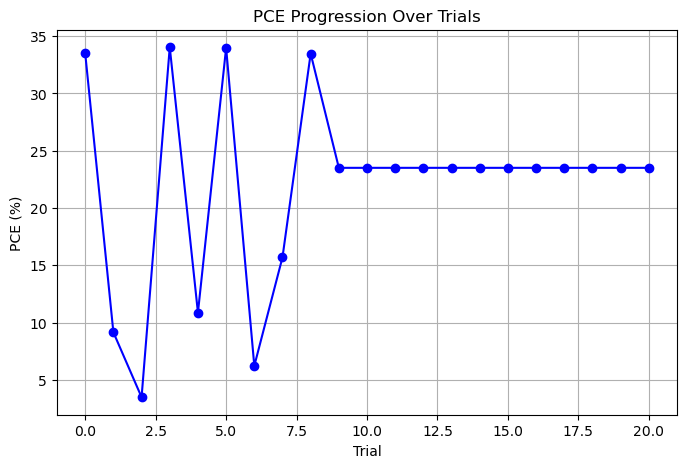

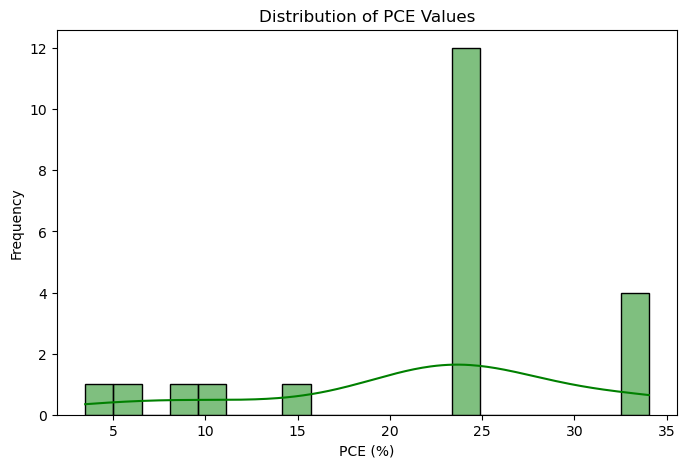

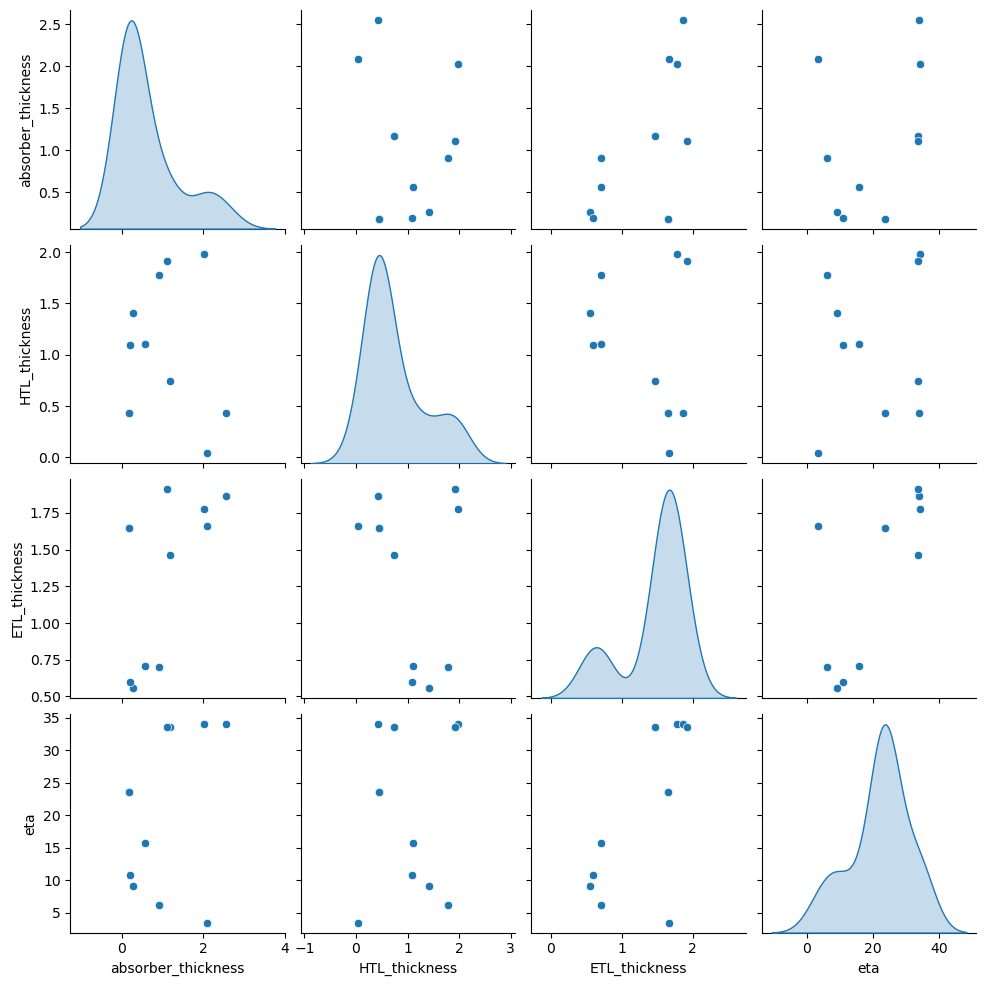

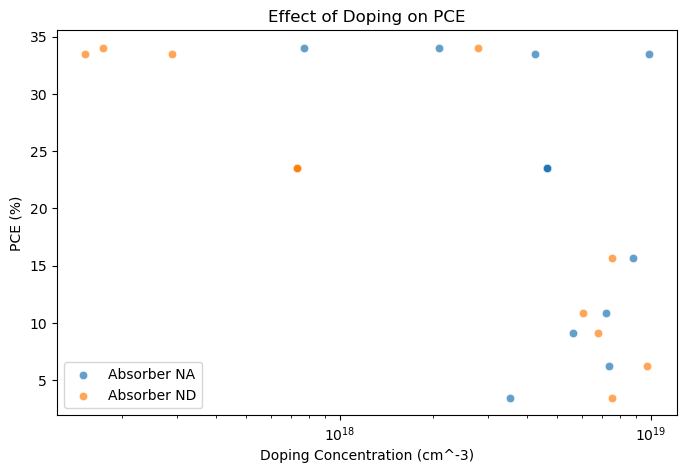

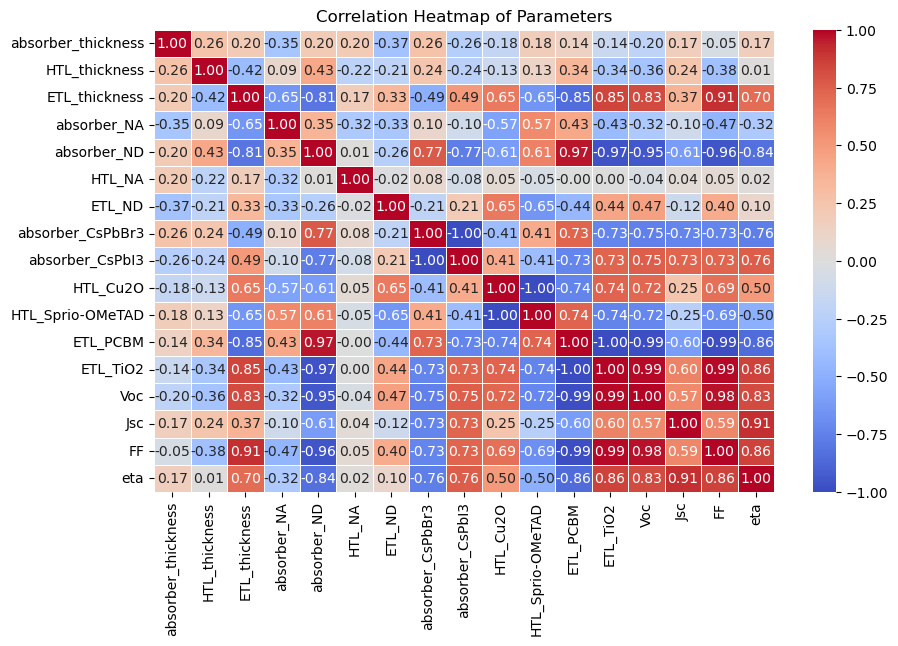

In [6]:


# Load dataset
instances_opt_df = pd.read_csv("updated_instances.csv")

# PCE Progression Over Trials
plt.figure(figsize=(8, 5))
plt.plot(instances_opt_df.index, instances_opt_df["eta"], marker='o', linestyle='-', color='b')
plt.xlabel("Trial")
plt.ylabel("PCE (%)")
plt.title("PCE Progression Over Trials")
plt.grid()
plt.show()

# Histogram of PCE Values
plt.figure(figsize=(8, 5))
sns.histplot(instances_opt_df["eta"], bins=20, kde=True, color='g')
plt.xlabel("PCE (%)")
plt.ylabel("Frequency")
plt.title("Distribution of PCE Values")
plt.show()

# Pairplot of Thickness vs. PCE
sns.pairplot(instances_opt_df, vars=["absorber_thickness", "HTL_thickness", "ETL_thickness", "eta"], diag_kind='kde')
plt.show()

# Scatter Plot of Doping vs. PCE
plt.figure(figsize=(8, 5))
sns.scatterplot(x=instances_opt_df["absorber_NA"], y=instances_opt_df["eta"], label='Absorber NA', alpha=0.7)
sns.scatterplot(x=instances_opt_df["absorber_ND"], y=instances_opt_df["eta"], label='Absorber ND', alpha=0.7)
plt.xscale("log")
plt.xlabel("Doping Concentration (cm^-3)")
plt.ylabel("PCE (%)")
plt.title("Effect of Doping on PCE")
plt.legend()
plt.show()

# Heatmap of Correlations
plt.figure(figsize=(10, 6))
corr = instances_opt_df.corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Parameters")
plt.show()
